In [65]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_memberships, plot
from itertools import combinations

In [2]:
TOOL_DIR = "tools"
tools = os.listdir(TOOL_DIR)
tools

['find_circ.csv',
 'segemehl.csv',
 'dcc.csv',
 'circexplorer2.csv',
 'ciriquant.csv']

In [3]:
n_plots = len(tools)
n_cols = 2
n_rows = n_plots // n_cols + 1

In [4]:
def parse_locstring(locstring: str):
    # Example: chr19:3528277-3542515:-
    chrom, coords, strand = locstring.split(":")
    start, end = coords.split("-")
    return chrom, int(start), int(end), strand

In [5]:
tool_counts = {}
tool_stats = {}
tool_loc = {}

for tool in tools:
    tool_name = tool[:-4]
    df = pd.read_csv(os.path.join(TOOL_DIR, tool), sep='\t', index_col=0)
    df.fillna(0, inplace=True)
    tool_counts[tool] = df
    
    df_stats = pd.DataFrame(index=df.index)
    df_stats["n_samples"] = (df>0).sum(axis=1)
    df_stats["total_counts"] = df.sum(axis=1)
    df_stats["tc_corrected"] = df_stats["total_counts"] - df_stats["n_samples"]
    tool_stats[tool] = df_stats

    df_loc = pd.DataFrame([parse_locstring(loc) for loc in df.index], columns=["chrom", "start", "end", "strand"], index=df.index)
    df_loc["tool"] = tool_name
    tool_loc[tool] = df_loc

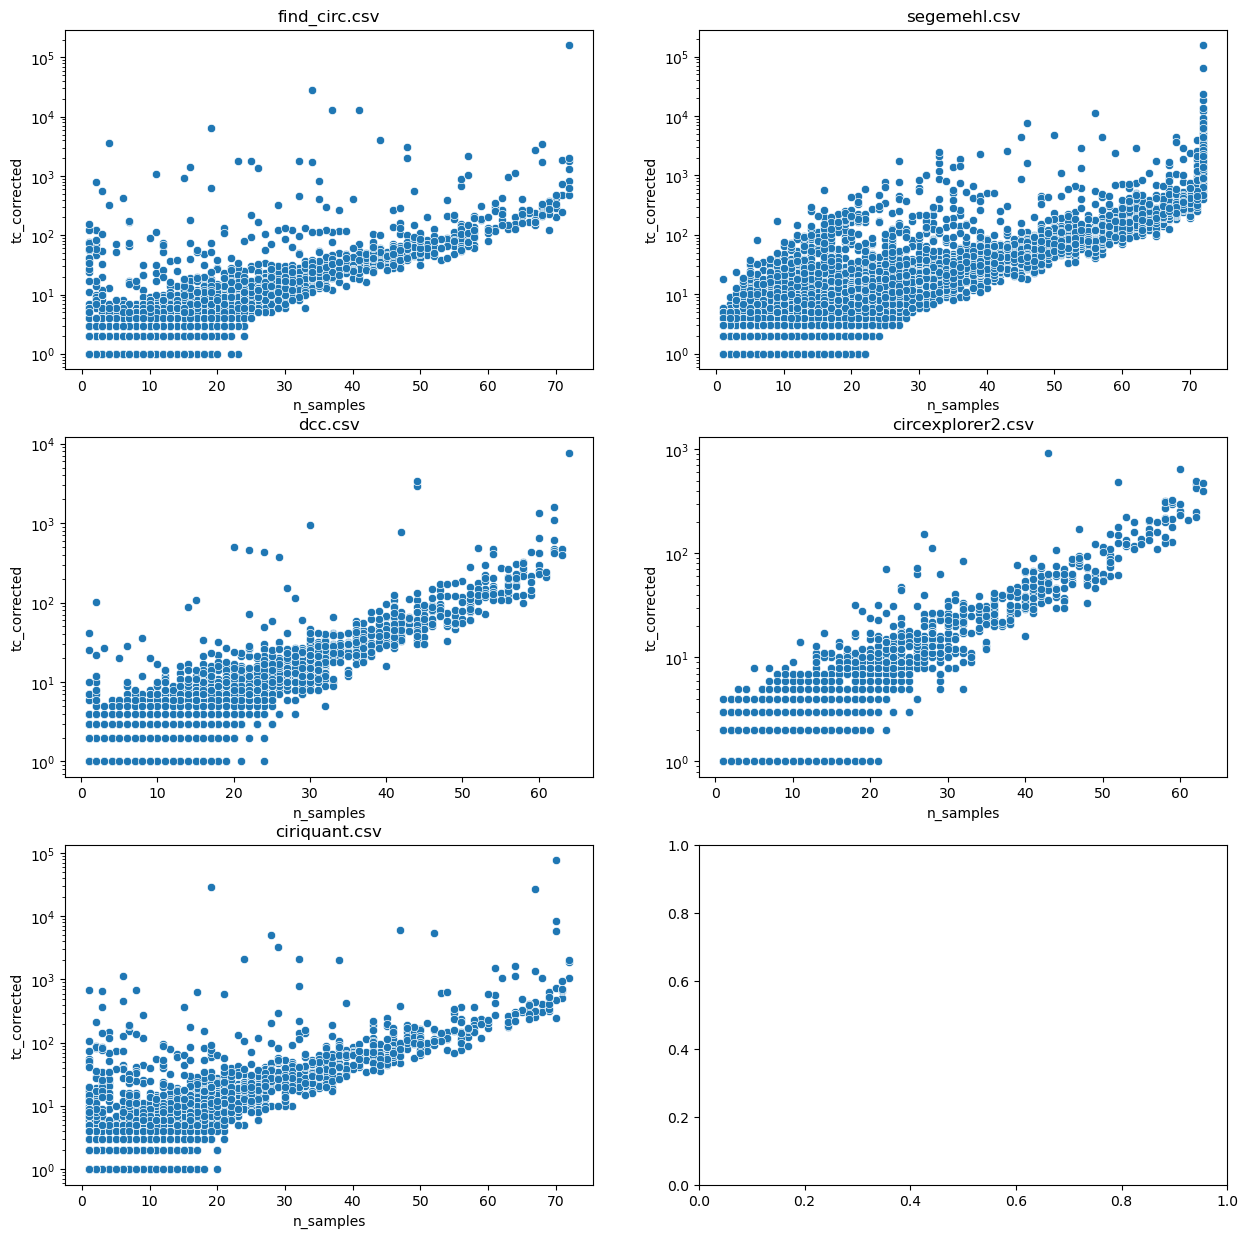

In [6]:
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

for i, tool in enumerate(tools):
    df_stats = tool_stats[tool]
    ax = axs.flatten()[i]
    sns.scatterplot(x="n_samples", y="tc_corrected", data=df_stats, ax=ax)
    ax.set_title(tool)

    ax.set_yscale("log")

In [7]:
df_locs = pd.concat(tool_loc.values(), axis=0)
df_locs

,chrom,start,end,strand,tool
id,,,,,
chr11:79826884-79828550:+,chr11,79826884,79828550,+,find_circ
chr9:96474002-96493552:-,chr9,96474002,96493552,-,find_circ
chr4:132384003-132400343:+,chr4,132384003,132400343,+,find_circ
chr19:29790163-29790287:-,chr19,29790163,29790287,-,find_circ
chr6:117820213-130549329:+,chr6,117820213,130549329,+,find_circ
...,...,...,...,...,...
chr19:10075708-10075862:-,chr19,10075708,10075862,-,ciriquant
chr8:11831155-11872049:+,chr8,11831155,11872049,+,ciriquant
chr9:107664451-107677972:-,chr9,107664451,107677972,-,ciriquant


([<matplotlib.axis.XTick at 0x734809072060>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5')])

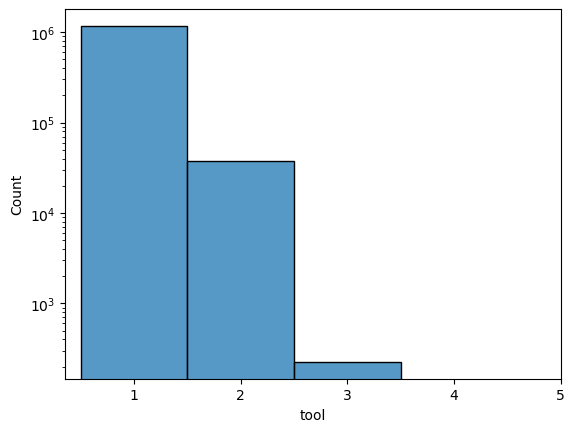

In [8]:
df_grouped_all = df_locs.groupby(["chrom", "start", "end", "strand"]).aggregate({"tool": "nunique"})
sns.histplot(df_grouped_all["tool"], discrete=True)
plt.yscale("log")
plt.xticks(range(1, len(tools)+1))

([<matplotlib.axis.XTick at 0x7348091acdd0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5')])

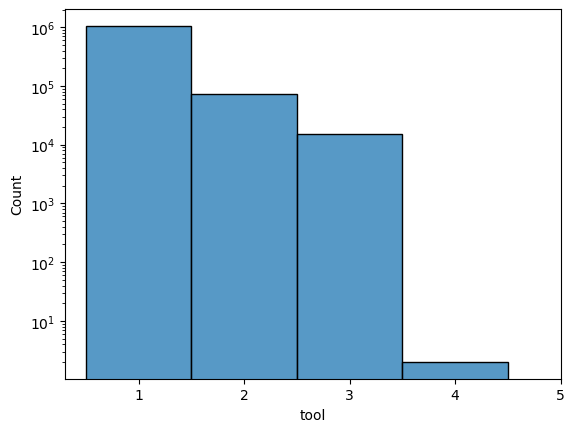

In [9]:
df_grouped_nostrand = df_locs.groupby(["chrom", "start", "end"]).aggregate({"tool": "nunique"})
sns.histplot(df_grouped_nostrand["tool"], discrete=True)
plt.yscale("log")
plt.xticks(range(1, len(tools)+1))

In [10]:
def diff_group(max_diff=1):
    df_diff = df_locs.sort_values(["chrom", "start"])
    df_diff["start_group"] = df_diff.groupby("chrom")["start"].diff().gt(max_diff).cumsum()
    df_diff = df_diff.sort_values(["chrom", "end"])
    df_diff["end_group"] = df_diff.groupby("chrom")["end"].diff().gt(max_diff).cumsum()

    return df_diff

In [16]:
diffs = [0, 1, 2, 3, 4, 5, 10, 20, 50, 100, 200, 500, 1000]
diff_df = {diff: diff_group(diff) for diff in diffs}

In [17]:
diff_valuecounts = {}
for diff in diff_df:
    df_diff = diff_df[diff]
    df_grouped = df_diff.groupby(["chrom", "start_group", "end_group"]).aggregate({"tool": "nunique"})
    value_counts = df_grouped["tool"].value_counts()
    diff_valuecounts[diff] = value_counts

In [18]:
df_diff_valuecounts = pd.DataFrame(diff_valuecounts).T
df_diff_valuecounts.index.name = "max_diff"
df_diff_valuecounts.fillna(0, inplace=True)
df_diff_valuecounts

tool,1,2,3,4,5
max_diff,,,,,
0,1056544.0,72685.0,15368.0,2.0,0.0
1,944079.0,28216.0,24107.0,14776.0,14223.0
2,904737.0,29054.0,26283.0,14770.0,14208.0
3,874100.0,29969.0,28026.0,14758.0,14197.0
4,848084.0,30981.0,29493.0,14768.0,14198.0
5,827189.0,31864.0,30527.0,14785.0,14201.0
10,760409.0,34281.0,32127.0,14783.0,14198.0
20,705023.0,34726.0,31871.0,14770.0,14197.0
50,620410.0,36068.0,31317.0,14785.0,14207.0


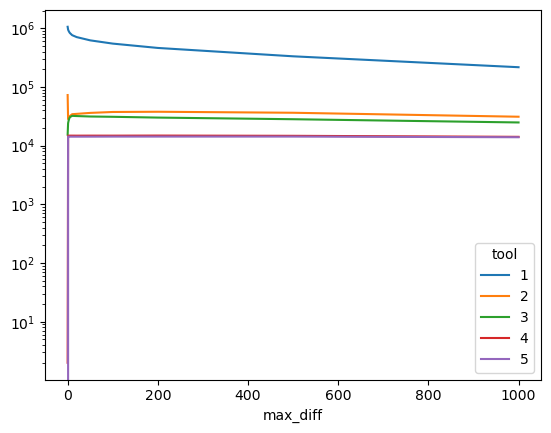

In [23]:
# Plot line plot
df_diff_valuecounts.plot()
plt.yscale("log")

In [24]:
diff_plotdata = {}

for i, diff in enumerate(diffs):
    df_diff = diff_df[diff]
    df_grouped = df_diff.groupby(["chrom", "start_group", "end_group"]).aggregate({"tool": list})
    plotdata = from_memberships(df_grouped["tool"])
    diff_plotdata[diff] = plotdata

/home/nico/miniconda3/envs/thesis-plots/lib/python3.12/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/nico/miniconda3/envs/thesis-plots/lib/python3.12/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/nico/miniconda3/envs/thesis-plots/lib/python3.12/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call 

/home/nico/miniconda3/envs/thesis-plots/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/nico/miniconda3/envs/thesis-plots/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we 

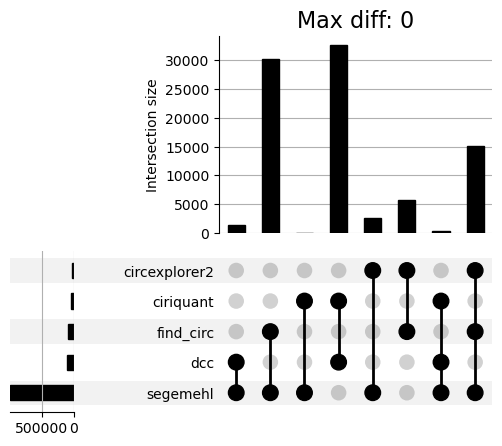

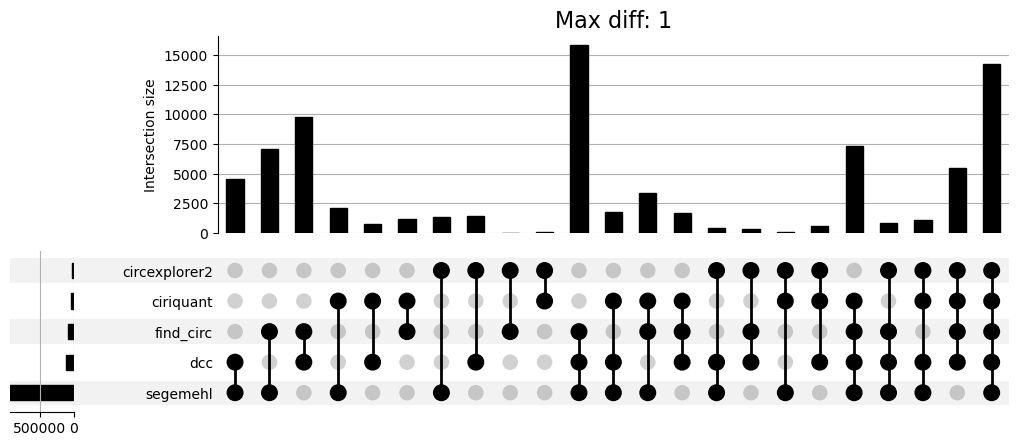

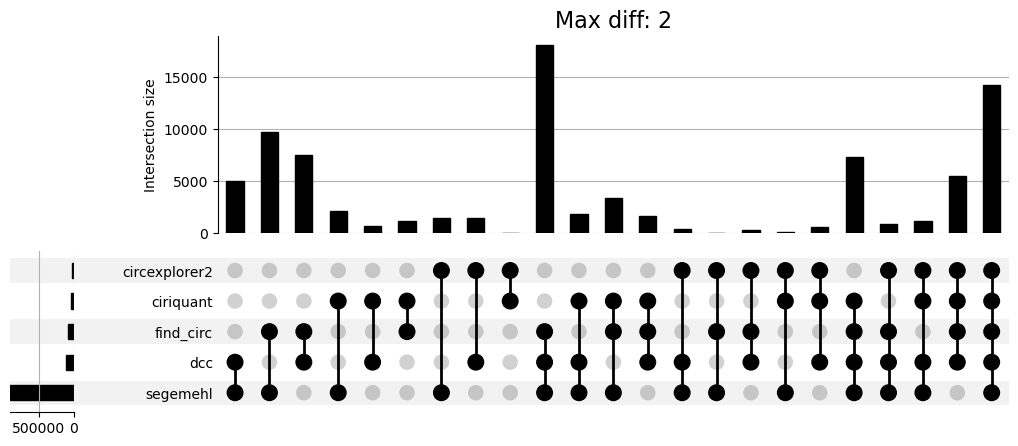

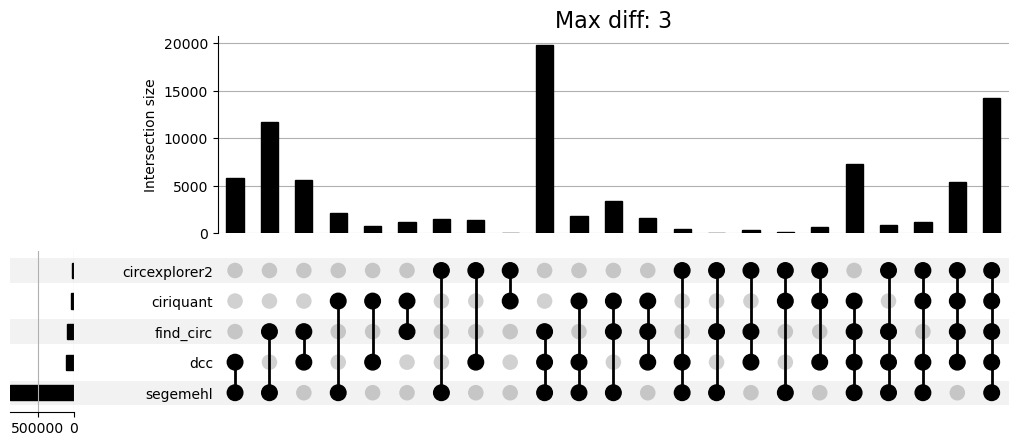

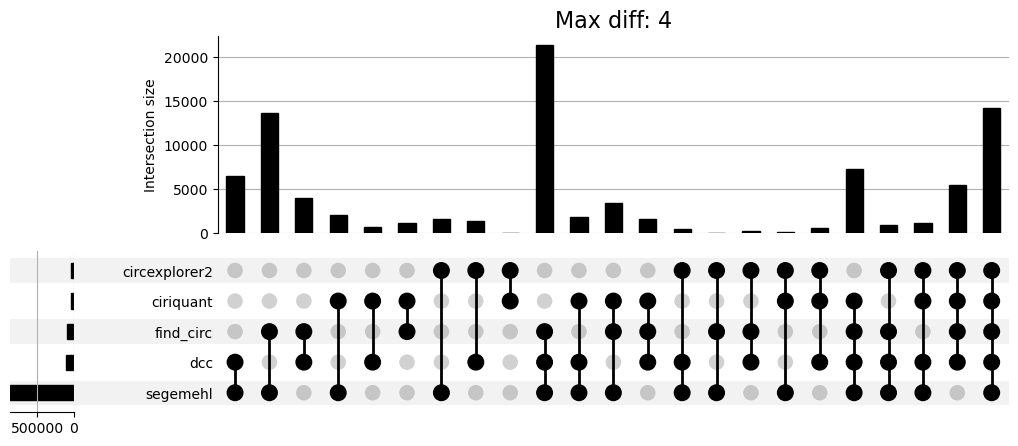

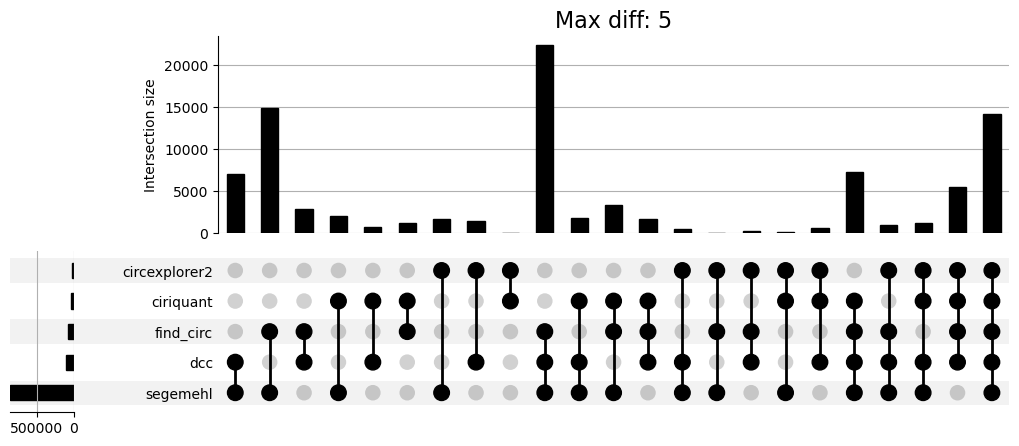

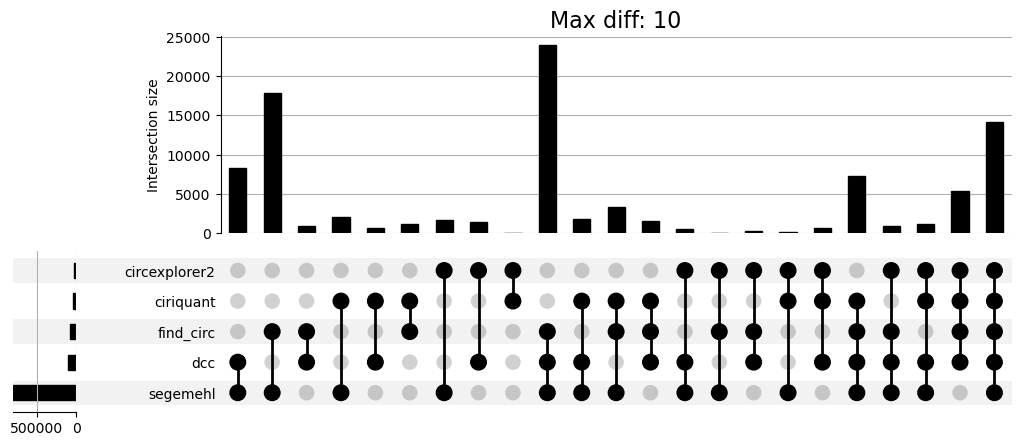

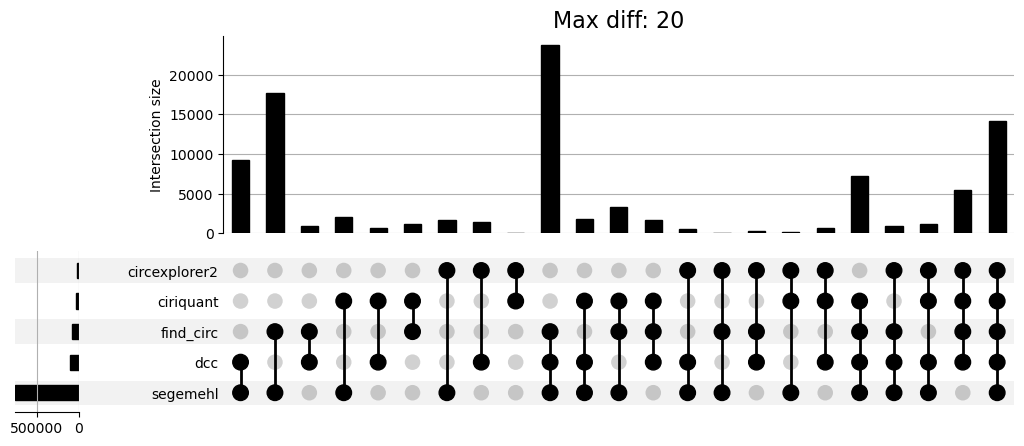

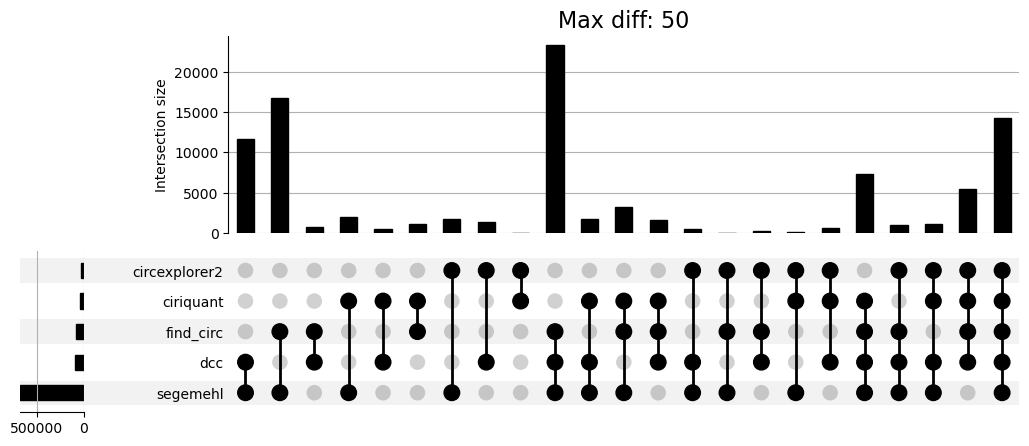

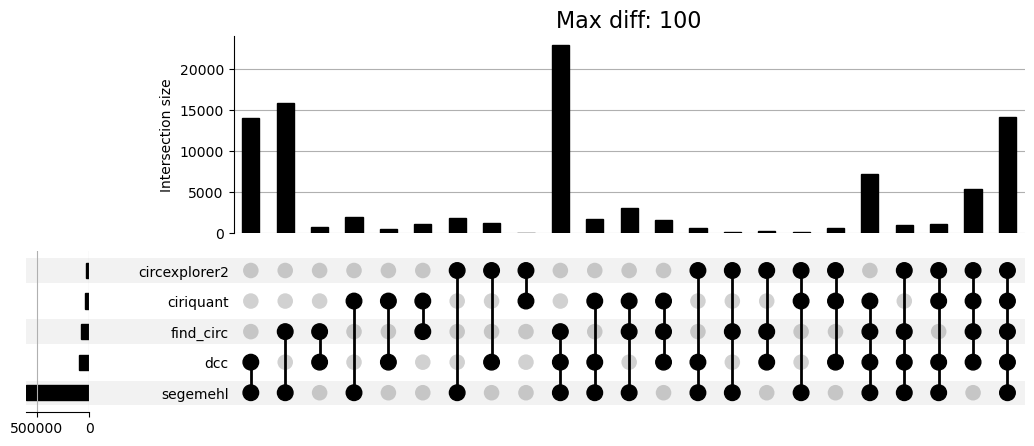

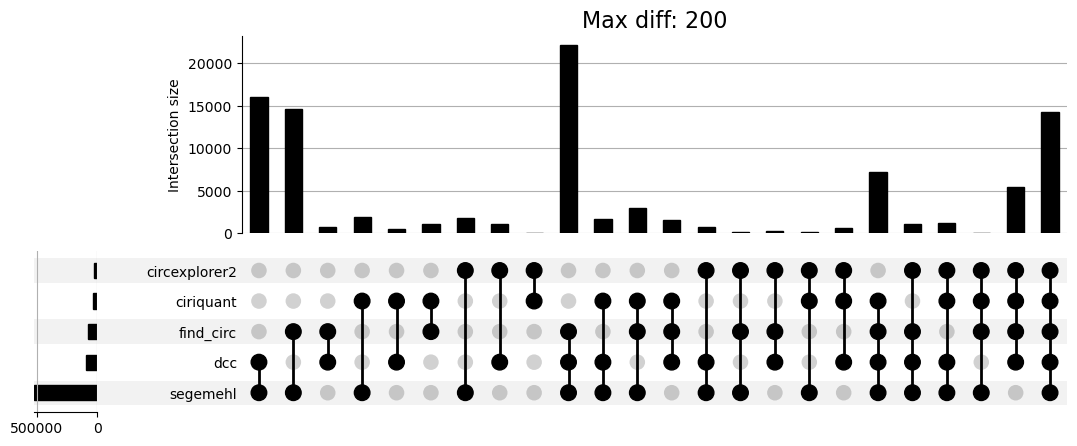

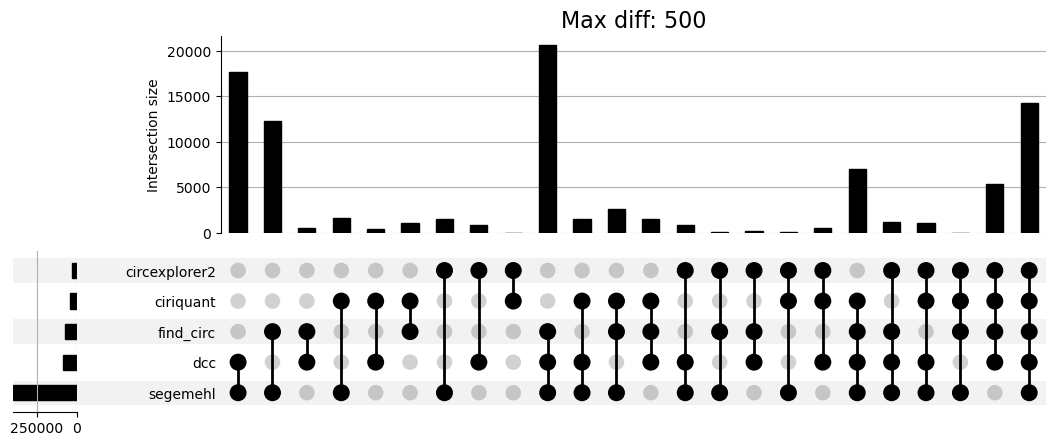

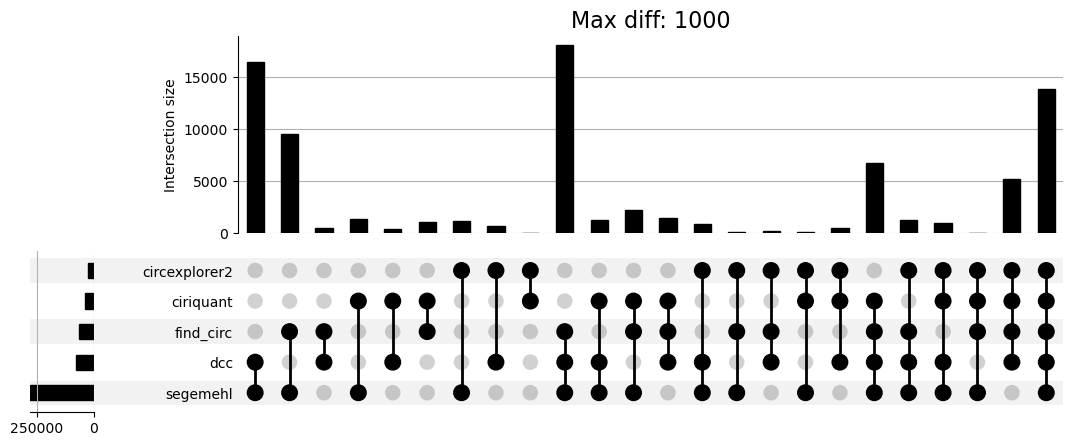

In [25]:
for i, diff in enumerate(diffs):
    plotdata = diff_plotdata[diff]
    upset = UpSet(plotdata, subset_size="count", min_degree=2, min_subset_size=10)
    upset.plot()
    plt.title(f"Max diff: {diff}", fontsize=16)

[]

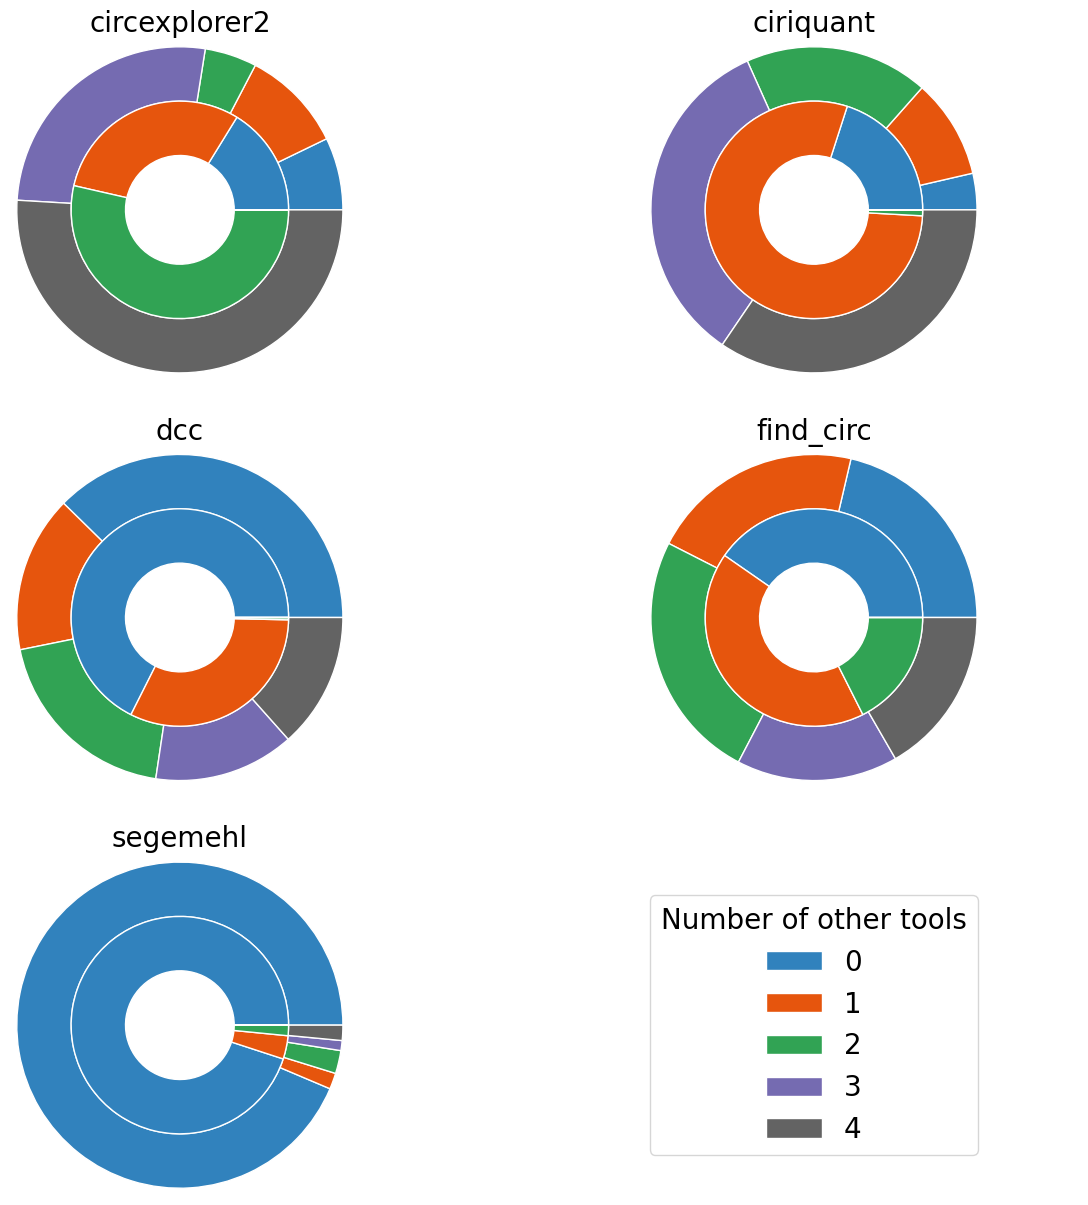

In [75]:
tools = ['circexplorer2', 'ciriquant', 'dcc', 'find_circ', 'segemehl']

font_size = 20

n_cols = 2
n_rows = len(tools) // n_cols + 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

def get_count(investigation, diff=0):
    index = [[investigation[tool] for tool in tools]]
    return diff_plotdata[diff].loc[index].sum() if diff_plotdata[diff].index.isin(index).any() else 0

cmap = plt.colormaps["tab20c"]
colors = cmap(np.arange(len(tools))*4)

for i, tool in enumerate(tools):
    others = [t for t in tools if t != tool]
    diff_overlaps = {}
    for diff in [0,1]:
        n_counts = {}
        for n_others in range(len(tools)):
            sum_count = 0
            for other_tools in combinations(others, n_others):
                investigation = {t: t in other_tools + (tool,) for t in tools}
                sum_count += get_count(investigation, diff)
            n_counts[n_others] = sum_count
        diff_overlaps[diff] = n_counts
    
    df_overlaps = pd.DataFrame(diff_overlaps).T
    
    size = 0.4

    ax = axs.flatten()[i]
    ax.pie(df_overlaps.loc[1], radius=1.2, wedgeprops=dict(width=size, edgecolor='w'), colors=colors)
    wedges, texts = ax.pie(df_overlaps.loc[0], radius=1.2-size, wedgeprops=dict(width=size, edgecolor='w'), colors=colors)
    ax.set_title(tool, fontsize=font_size)

ax = axs.flatten()[-1]
legend = ax.legend(wedges, range(len(tools)), title="Number of other tools", loc='center', fontsize=font_size)

plt.setp(legend.get_title(), fontsize=font_size)

for direction in ['top', 'right', 'left', 'bottom']:
    ax.spines[direction].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])